In [1]:
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from matplotlib.colors import ListedColormap
import os
import matplotlib as mpl

C:\Users\kpebe\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kpebe\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\kpebe\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def edit_dat(n,m,number_of_cycles,m1,filepath_import,line_to_replace): # эта функция преобразует начальные файлики в нормальный вид
    
    n1 = 2 + 2 * number_of_cycles
    for i in range(0,n):
        for j in range(0,m):
            filepath = filepath_import.format(i+1,j+1)
            f = open(filepath, "r")
            lines = f.readlines()
            f.close()
            f = open(filepath, "w")
            for line in lines:
                if line != line_to_replace:
                    line = line.replace(',', '.')
                    line = line.replace('0.00000E+0', '1.00000E-12')
                    line = line.replace('-0.00000E+0', '1.00000E-12')
                    f.write(line) 
    f.close()

In [3]:
def dat_to_csv(n,m,number_of_cycles,m1,filepath_dat_import,filepath_csv_import): # эта функция делает csv файлы из начальных
    
    n1 = 2 + 2 * number_of_cycles
    for i in range(0,n):
        for j in range(0,m):
            filepath_dat = filepath_dat_import.format(i+1,j+1)
            filepath_csv = filepath_csv_import.format(i+1,j+1)
            with open(filepath_dat) as f:
                with open(filepath_csv, "w") as f1:
                    for line in f:
                        f1.write(line)
    f.close()
    f1.close()

In [4]:
def calculation_and_export(n,m,number_of_cycles,m1,filepath_csv1_import,filepath_csv2_export,filepath_heatmap_export,filepath_graph_export, filepath_mobmap_export,filepath_heatmap_gate_export): # эта функция делает весь нужный расчет
    
    values = {-3, -2, -1}
    colors = {"Red", "Pink", "Brown"}
    n1 = 2 + 2 * number_of_cycles
    u = np.array([n,m,n1,m1])
    x = np.ndarray((u), dtype = float) # это четырехмерный тензор, содержащий все данные в себе
    y = np.zeros((n,m)) # это матрица для отношения тока включения к току выключения
    z = np.zeros((m1,number_of_cycles)) # это массив для токов для транзистора (то есть по одному транзистору)
    zg = np.zeros((m1,number_of_cycles)) # это массив сопротивления гейта для каждого напряжения, чтоб проверить, не пробит ли он
    yg = np.zeros((n,m)) # это матрица сопротивлений гейта
    ylog = np.zeros((n,m)) # это матрица с логарифмами отношения тока включения к току выключения
    q = np.zeros((n,m,number_of_cycles))
    yder = np.ndarray((n,m,number_of_cycles,m1-2), dtype = float)
    yder2 = np.ndarray((n,m,m1-2), dtype = float)
    ymob = np.zeros((n,m))
    max1 = int(0)
    max2 = int(m1-1)
    min1 = int((m1-2)/2)
    min2 = int((m1-2)/2+1)
    max_currents = np.zeros((n,m))
    min_currents = np.zeros((n,m))
    open_state_resistance = np.zeros((n,m))
    
    # этот цикл заполняет четырехмерный тензор всеми данными по чипу
    for i in range(0,n):
        for j in range(0,m):
            filepath_csv = filepath_csv1_import.format(i+1,j+1)
            df = pd.read_csv(filepath_csv, engine = 'python', sep = '	')
            for k in range (0,n1):
                for l in range (0, m1):
                    try:
                        x[i,j,k,l] = df.iloc[l,k]
                    except:
                        x[i,j,k,l] = 10 ** (-12)
                        pass
                    
    # этот цикл считает отношение тока включения к току выключения
    for i in range(0,n):
        for j in range(0,m):
            for l in range (0, m1):
                for k in range (0,number_of_cycles):
                    z[l,k] = x[i,j,2+2*k,l]
                    if z[l,k] < 10 ** (-12):
                        z[l,k] = 10 ** (-12)
                    if np.float(x[i,j,1,l]) != 0.:            
                        zg[l,k] = abs(x[i,j,1,l]/x[i,j,3+2*k,l])
                    else:
                        zg[l,k] = 0
            yg[i,j] = np.sum(sum(zg))/(len(zg)-1)
            #for k in range (0, number_of_cycles):
            max_currents[i,j] = np.mean(z[max1:max1+6,:]) + np.mean(z[max2-6:max2,:])
            min_currents[i,j] = np.mean(z[min1-6: min1,:]) + np.mean(z[min2:min2+6,:])
            max_currents[i,j] /= number_of_cycles
            min_currents[i,j] /= number_of_cycles
            y[i,j] = max_currents[i,j]/min_currents[i,j]
           # if y[i,j] < 30:
             #   y[i,j] = -2 # трубка совсем металлическая
           # if  np.float(np.sum(np.sum(z)))/len(z) < 10 ** (-9):
            #    y[i,j] = -1 # не проводящий транзистор
    
    # этот цикл считает десятичный логарифм отношения тока включения к току выключения
    for i in range(0,n):
        for j in range(0,m):
            if y[i,j] > 0:
                #if yg[i,j] > 10 ** 10:
                ylog[i,j] = round(math.log10(y[i,j]), 4)
               # else:
                    #ylog[i,j] = -3 # пробит gate
            #else:
             #   if yg[i,j] > 10 ** 10:
              #      ylog[i,j] = y[i,j]
               # else:
                #    ylog[i,j] = -3
                
    # тут делается dataframe с логаримфами отношения тока включения к току выключения с создается соответствующий csv
    dfc = pd.DataFrame(ylog)
    dfc.columns = range(1,m+1)
    dfc.index = range(1,n+1)
    pd.DataFrame.to_csv(dfc, path_or_buf = filepath_csv2_export, sep = "	", index = False, header = True)
    
    # эта штука делает heatmap для токов
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(dfc, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    plt.title('Log10 of on/off ratio.' + '\n' + '-1 = Non-conductive' + '\n' + '-2 = Low on/off ratio' + '\n' + '-3 = Gate leakage')
    fig.savefig(filepath_heatmap_export)
    plt.clf()
    
    # эта штука делает heatmap для сопротивлений гейта
    plt.clf()
    for i in range(0,n):
        for j in range(0,m):
            yg[i,j] = round(math.log10(yg[i,j]),2)
    dfyg = pd.DataFrame(yg)
    dfyg.columns = range(1,m+1)
    dfyg.index = range(1,n+1)
    sns.heatmap(dfyg, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    fig.savefig(filepath_heatmap_gate_export)
    plt.clf()
    
    # этот цикл сохраняет графики у хороших транзисторов
    vx = np.ndarray((n,m,number_of_cycles,m1), dtype = float)
    for i in range(0,n):
        for j in range(0,m):
            for k in range(0, number_of_cycles):
                for l in range(0,m1):
                    vx[i,j,k,l] = round(math.log10(abs(x[i,j,2+2*k,l])),2)
    for i in range(0,n):
        for j in range(0,m):
            #if ylog[i,j] >= 0:
            for k in range(0, number_of_cycles):
                plt.clf()
                plt.plot(x[i,j,1], x[i,j,2], label = '1st cycle')
                plt.plot(x[i,j,1], x[i,j,4], label = '2nd cycle')
                plt.title('FET {}_{}'.format(i+1, j+1))
                plt.xlabel('V gate, V', fontsize = 18)
                plt.ylabel('I, A', fontsize = 18)
                plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                plt.legend(('1st cycle', '2nd cycle'))
            plt.savefig(filepath_graph_export.format(i+1,j+1), format = "png")
            plt.clf()
    
    # тут сглаживаются графики
    for i in range(0,n):
        for j in range(0,m):
            for k in range(0,number_of_cycles):
                for l in range(1,m1-1):
                    if abs(x[i,j,2*k+2,l-1]/x[i,j,2*k+2,l]) < 0.33 or abs(x[i,j,2*k+2,l-1]/x[i,j,2*k+2,l]) > 3:
                        x[i,j,2*k+2,l] = x[i,j,2*k+2,l-1]
    
    # здесь считается мобильность
    for i in range(0,n):
        for j in range(0,m):
            if y[i,j] > 0:
                for k in range(0,number_of_cycles):
                    for l in range(1,m1-1):
                        if x[i,j,1,l] != x[i,j,1,l-1]:
                            yder[i,j,k,l-1] = abs((x[i,j,2*k+2,l] - x[i,j,2*k+2,l-1])/(x[i,j,1,l] - x[i,j,1,l-1]))
                        else:
                            yder[i,j,k,l-1] = 0
            else:
                for k in range(0,number_of_cycles):
                    for l in range(1,m1-1):
                        yder[i,j,k,l-1] = 0
            for k in range(0,number_of_cycles):
                for l in range(1,m1-1):
                    yder2[i,j,l-1] = yder2[i,j,l-1] + yder[i,j,k,l-1]
            if y[i,j] > 0:
                ymob[i,j] = abs(np.amax(yder2[i,j])/number_of_cycles/x[0,0,0,0])
            else:
                ymob[i,j] = 0
            if ymob[i,j] != 0:
                ymob[i,j] = math.log10(ymob[i,j])
    
    # здесь делается карта мобильностей
    plt.clf()
    dfmob = pd.DataFrame(ymob)
    dfmob.columns = range(1,m+1)
    dfmob.index = range(1,n+1)
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(dfmob, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    fig.savefig(filepath_mobmap_export)
    plt.clf()
    
    # здесь строится карта сопротивлений транзисторов в открытом состоянии
    for i in range(0,n):
        for j in range(0,m):
            open_state_resistance[i,j] = x[i,j,0,0]/max_currents[i,j]
    df_open_state_resistance = pd.DataFrame(np.log10(open_state_resistance))
    df_open_state_resistance.columns = range(1,m+1)
    df_open_state_resistance.index = range(1,n+1)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df_open_state_resistance, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    fig.savefig(r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\open_state_resistance.png", format = 'png')

In [5]:
def whole_calc(n,m, number_of_cycles, m1, filepath):
    
    # здесь делаются csvшки на основе dat
    
    n1 = 2 + 2 * number_of_cycles
    new_folder = filepath + r'\changed_dat'
    try:
        os.makedirs(new_folder)
    except:
        pass
    for i in range(0,n):
        for j in range(0,m):
            filepath_dat = (filepath + r'\dat\fet_{}_{}.dat').format(i+1,j+1)
            f = open(filepath_dat, "r")
            lines = f.readlines()
            lines.pop(1)
            f.close()
            f = open((filepath + r'\changed_dat\fet_{}_{}.dat').format(i+1,j+1), 'w')
            for line in lines:
                line = line.replace(',', '.')
                line = line.replace('0.00000E+0', '1.00000E-12')
                line = line.replace('-0.00000E+0', '1.00000E-12')
                f.write(line) 
    f.close()
    new_folder = filepath + '\csv'
    try:
        os.makedirs(new_folder)
    except:
        pass
    for i in range(0,n):
        for j in range(0,m):
            filepath_dat = (filepath + r'\changed_dat\fet_{}_{}.dat').format(i+1,j+1)
            filepath_csv = (filepath + r'\csv\fet_{}_{}.csv').format(i+1,j+1)
            with open(filepath_dat) as f:
                with open(filepath_csv, "w") as f1:
                    for line in f:
                        f1.write(line)
    f.close()
    f1.close()
    
    # инициализация всяких массивов и нужных переменных
    
    data = np.ndarray(([n, m, n1, m1]), dtype = float) # это четырехмерный тензор, содержащий все данные в себе
    on_off_ratio = np.zeros((n,m)) # это матрица для отношения тока включения к току выключения
    single_transistor_currents = np.zeros((m1,number_of_cycles)) # это массив для токов для транзистора (то есть по одному транзистору)
    single_transistor_gate_resistance = np.zeros((m1,number_of_cycles)) # это массив сопротивления гейта для каждого напряжения, чтоб проверить, не пробит ли он
    gate_resistance = np.zeros((n,m)) # это матрица сопротивлений гейта
    log10_on_off_ratio = np.zeros((n,m)) # это матрица с логарифмами отношения тока включения к току выключения
    max1, max2, min1, min2 = int(0), int(m1-1), int((m1-2)/2), int((m1-2)/2+1) # это точки где токи должны быть максимальны или минимальны, то есть по краям графиков
    max_currents, min_currents = np.zeros((n,m)), np.zeros((n,m)) # массивы максимальных и минимальных токов, нужны для рассчета on/off
    open_state_resistance = np.zeros((n,m)) # массив сопротивлений транзисторов в открытом состоянии
    
    # этот цикл заполняет четырехмерный тензор всеми данными по чипу
    for i in range(0,n):
        for j in range(0,m):
            filepath_csv = (filepath + r'\csv\fet_{}_{}.csv').format(i+1,j+1)
            df = pd.read_csv(filepath_csv, engine = 'python', sep = '	')
            for k in range (0,n1):
                for l in range (0, m1):
                    data[i,j,k,l] = df.iloc[l,k]
                    
    # этот цикл считает отношение тока включения к току выключения
    for i in range(0,n):
        for j in range(0,m):
            for l in range (0, m1):
                for k in range (0,number_of_cycles):
                    single_transistor_currents[l,k] = data[i,j,2+2*k,l]
                    if single_transistor_currents[l,k] < 10 ** (-12):
                        single_transistor_currents[l,k] = 10 ** (-12)
                    if np.float(data[i,j,1,l]) != 0.:            
                        single_transistor_gate_resistance[l,k] = abs(data[i,j,1,l]/data[i,j,3+2*k,l])
                    else:
                        single_transistor_gate_resistance[l,k] = 10 ** (-12)
            gate_resistance[i,j] = np.mean(single_transistor_gate_resistance[:])
            max_currents[i,j] = np.mean(single_transistor_currents[max1:max1+6,:]) + np.mean(single_transistor_currents[max2-6:max2,:])
            min_currents[i,j] = np.mean(single_transistor_currents[min1-6:min1,:]) + np.mean(single_transistor_currents[min2:min2+6,:])
            max_currents[i,j] /= number_of_cycles
            min_currents[i,j] /= number_of_cycles
            on_off_ratio[i,j] = max_currents[i,j]/min_currents[i,j]
            log10_on_off_ratio[i,j] = np.log10(on_off_ratio[i,j])
            if on_off_ratio[i,j] < 10:
                log10_on_off_ratio[i,j] = -2 # трубка совсем металлическая
            if  max_currents[i,j] < 10 ** (-10):
                log10_on_off_ratio[i,j] = -1 # не проводящий транзистор
            if gate_resistance[i,j] < 10 ** 10:
                log10_on_off_ratio[i,j] = -3 # пробитый gate
           
    # эта штука делает csv и heatmap с on/off ratio
    df = pd.DataFrame(log10_on_off_ratio)
    df.columns = range(1,m+1)
    df.index = range(1,n+1)
    pd.DataFrame.to_csv(df, path_or_buf = (filepath + r'\On_off_ratio.csv'), sep = "	", index = False, header = True)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    plt.title('Log10 of on/off ratio.' + '\n' + '-1 = Non-conductive' + '\n' + '-2 = Low on/off ratio' + '\n' + '-3 = Gate leakage')
    fig.savefig((filepath + r'\On_off_ratio.png'), format = 'png')
    plt.clf()
    
    
    # здесь строится карта сопротивлений транзисторов в открытом состоянии
    for i in range(0,n):
        for j in range(0,m):
            open_state_resistance[i,j] = data[i,j,0,0]/max_currents[i,j]
    df = pd.DataFrame(np.log10(open_state_resistance))
    df.columns = range(1,m+1)
    df.index = range(1,n+1)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    plt.title('Log10 open state resistance')
    fig.savefig((filepath + r'\Open_state_resistance.png'), format = 'png')
    plt.clf()
    
    # эта штука делает heatmap для сопротивлений гейта
    for i in range(0,n):
        for j in range(0,m):
            gate_resistance[i,j] = round(np.log10(gate_resistance[i,j]),2)
    df = pd.DataFrame(gate_resistance)
    df.columns = range(1,m+1)
    df.index = range(1,n+1)
    sns.heatmap(df, linewidth = .3, annot = True, fmt = ".2g", ax = ax, cbar = True)
    plt.title('Log10 gate resistance')
    fig.savefig((filepath + r'Gate resistance.png'), format = 'png')
    plt.clf()
    
    # этот цикл сохраняет графики всех транзисторов
    new_folder = filepath + r'\Graphs'
    try:
        os.makedirs(new_folder)
    except:
        pass
    for i in range(0,n):
        for j in range(0,m):
            for k in range(0, number_of_cycles):
                plt.plot(data[i,j,1], data[i,j,2+2*k], label = '{}st cycle'.format(k+1))
            plt.title('FET {}_{}'.format(i+1, j+1))
            plt.xlabel('V gate, V', fontsize = 18)
            plt.ylabel('I, A', fontsize = 18)
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            plt.savefig((filepath + r'\Graphs\fet_{}_{}.png').format(i+1,j+1), format = "png")
            plt.clf()
            
        # этот цикл сохраняет графики хороших транзисторов
    new_folder = filepath + r'\Good transistors graphs'
    try:
        os.makedirs(new_folder)
    except:
        pass
    for i in range(0,n):
        for j in range(0,m):
            if log10_on_off_ratio[i,j] > 0:
                for k in range(0, number_of_cycles):
                    plt.plot(data[i,j,1], data[i,j,2+2*k], label = '{}st cycle'.format(k+1))
                plt.title('FET {}_{}'.format(i+1, j+1))
                plt.xlabel('V gate, V', fontsize = 18)
                plt.ylabel('I, A', fontsize = 18)
                plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                plt.savefig((filepath + r'\Good transistors graphs\fet_{}_{}.png').format(i+1,j+1), format = "png")
                plt.clf()

In [8]:
edit_dat(2,4,2,402,r"C:\Users\kpebe\OneDrive\Рабочий стол\Transistor measurements old\23.09.19_Pristine_1.8lpm_80sec_0.85MOhm\1st measurement\data\fet_{}_{}.dat", 
         "		Cycle1	Cycle1	Cycle2	Cycle2" + "\n")

In [9]:
dat_to_csv(2,4,2,402,r"C:\Users\kpebe\OneDrive\Рабочий стол\Transistor measurements old\23.09.19_Pristine_1.8lpm_80sec_0.85MOhm\1st measurement\data\fet_{}_{}.dat", 
           r"C:\Users\kpebe\OneDrive\Рабочий стол\Transistor measurements old\23.09.19_Pristine_1.8lpm_80sec_0.85MOhm\1st measurement\data\fet_{}_{}.csv")

<Figure size 720x720 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

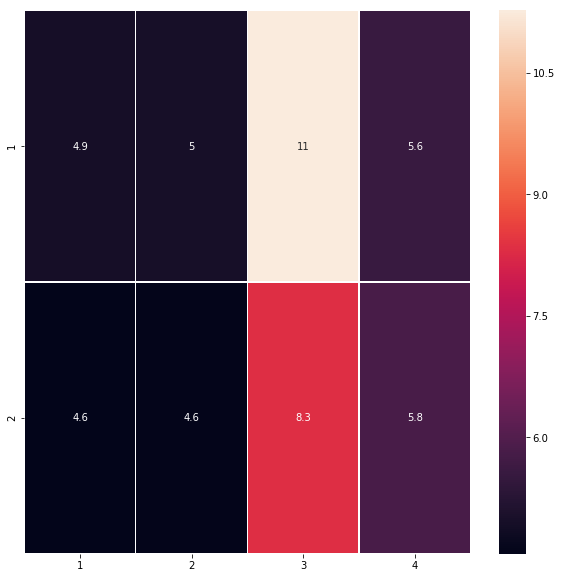

In [8]:
calculation_and_export(2,4,2,402,r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\csv\fet_{}_{}.csv", r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\fet_currents.csv", r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\heatmap_current_ratio.png", r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\Graphs\fet_{}_{}.png", r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\Mobility map.png",r"C:\Users\kpebe\OneDrive\Рабочий стол\1st\heatmap_gate_resistance.png")

In [43]:
whole_calc(2, 4, 2, 402, r'C:\Users\kpebe\OneDrive\Рабочий стол\12')

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.rcParams.update({'font.size': 12})

In [ ]:
np.log10?

In [ ]:
q = np.array([[1,2,3,4,5,6], [1,3,5,6,8,1]])
np.mean(q[2:5, 0])

In [ ]:
path = r'C:\Users\kpebe\OneDrive\Рабочий стол\2nd\changed_dat'
os.makedirs(path)

In [ ]:
u = r'C:\Users\kpebe\OneDrive\Рабочий стол\12'
u + r'\dat\fet_{}_{}.dat'

In [6]:
path = r'C:\Users\kpebe\OneDrive\Рабочий стол\Transistors\Measurements\Andrey\before\data'

In [12]:
os.listdir(path)

['fet_10_2.csv',
 'fet_10_3.csv',
 'fet_11_1.csv',
 'fet_11_2.csv',
 'fet_11_3.csv',
 'fet_12_1.csv',
 'fet_12_2.csv',
 'fet_12_3.csv',
 'fet_13_1.csv',
 'fet_13_2.csv',
 'fet_13_3.csv',
 'fet_14_1.csv',
 'fet_14_2.csv',
 'fet_14_3.csv',
 'fet_15_1.csv',
 'fet_15_2.csv',
 'fet_15_3.csv',
 'fet_16_1.csv',
 'fet_16_2.csv',
 'fet_16_3.csv',
 'fet_17_1.csv',
 'fet_17_2.csv',
 'fet_17_3.csv',
 'fet_18_1.csv',
 'fet_18_2.csv',
 'fet_18_3.csv',
 'fet_19_1.csv',
 'fet_19_2.csv',
 'fet_19_3.csv',
 'fet_1_2.csv',
 'fet_1_3.csv',
 'fet_20_1.csv',
 'fet_20_2.csv',
 'fet_20_3.csv',
 'fet_21_1.csv',
 'fet_21_2.csv',
 'fet_21_3.csv',
 'fet_22_1.csv',
 'fet_22_2.csv',
 'fet_22_3.csv',
 'fet_23_1.csv',
 'fet_23_2.csv',
 'fet_23_3.csv',
 'fet_24_1.csv',
 'fet_24_2.csv',
 'fet_24_3.csv',
 'fet_25_1.csv',
 'fet_25_2.csv',
 'fet_25_3.csv',
 'fet_26_1.csv',
 'fet_26_2.csv',
 'fet_26_3.csv',
 'fet_27_1.csv',
 'fet_27_2.csv',
 'fet_27_3.csv',
 'fet_28_1.csv',
 'fet_28_2.csv',
 'fet_28_3.csv',
 'fet_29_1.csv',

In [10]:
dfs = []
csvs = []
rows = 50
cols = 3
Imax = np.zeros((cols, rows))
Imin = np.zeros((cols, rows))
status_array = np.full((cols, rows), float('NaN'))
onoffs = np.zeros((cols, rows))

for i in range(1, cols+1):
    
    for j in range(1, rows+1):
    
        try:
            file = 'fet_{}_{}'.format(i,j)
            df = pd.read_csv(path + '\\' + '{}.csv'.format(file))[1:].astype(float)

            onoffs[i-1, j-1] = np.amax(abs(df['ISD']))/max(np.amin(abs(df['ISD'])), 1e-12)

            if np.amax(abs(df['ISD'])) < 10 ** (-9):  # условие для непроводящих

                onoffs[i-1, j-1] = float('NaN')
                status_array[i-1, j-1] = 1

            if np.amax(abs(df['IGD'])) > 1e-8:  # условие для пробитого гейта

                onoffs[i-1, j-1] = float('NaN')
                status_array[i-1, j-1] = 2

            if np.amax(abs(df['ISD'])) > 1e2 \
                or np.amin(abs(df['ISD'])) > 1e2 \
                or np.isnan(np.array(df[['ISD', 'VGD']])).any():  # Данные говно

                onoffs[i-1, j-1] = float('NaN')
                status_array[i-1, j-1] = 3

            dfs.append(df)
            csvs.append(file)
            
        except:

            onoffs[i-1, j-1] = float('NaN')
            status_array[i-1, j-1] = 3
                
        
onoffs[onoffs <= 1] = 1

In [11]:
csvs[0]

IndexError: list index out of range

In [8]:


for i in range(len(dfs)):
    
    fig, ax = plt.subplots(figsize = (6, 6))
    
    plt.plot(dfs[i]['VGD'], abs(dfs[i]['ISD']))
    maxt = max(dfs[i]['ISD']*np.sign(dfs[i]['VSD']))
    mint = min(dfs[i]['ISD']*np.sign(dfs[i]['VSD']))
    plt.title(csvs[i])
    plt.yscale('symlog', linthreshy=10 ** (-13))
    
    ax.yaxis.set_major_locator(mpl.ticker.SymmetricalLogLocator(base=10.0, linthresh=1e-13, subs=(0.1, 1, 10, 100,)))
    ax.yaxis.set_minor_locator(mpl.ticker.SymmetricalLogLocator(base=10.0, linthresh=1e-13, subs=(0.2, 0.4, 0.6, 0.8, 1,)))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    ticks = np.array(list(ax.axes.get_yticks()))
    ticks = ticks[(abs(ticks) > 5 * 1e-14) | (ticks == 0)]
    ticks = ticks[ticks < (maxt)]
    ticks = ticks[ticks > (mint)]
    ax.axes.set_yticks(ticks)
    plt.xlabel('Vg')
    plt.ylabel('Isd')
    plt.savefig(path + '\\' + csvs[i].split('.')[0] + '.png', format = 'png', dpi = 300)
    plt.close(fig)

C:\Users\kpebe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\kpebe\Anaconda3\lib\site-packages\seaborn\matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\kpebe\Anaconda3\lib\site-packages\seaborn\matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


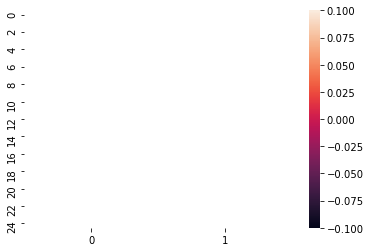

In [25]:
sns.heatmap((Imax/Imin).T)

In [9]:
fig, ax = plt.subplots(figsize = (6, 9))

patches = [mpl.patches.Patch(color='gray', label='Non-conductive'),
           mpl.patches.Patch(color='black', label='Gate leakage'),
           mpl.patches.Patch(color='rosybrown', label='No data')]

status_cmap = mpl.colors.ListedColormap(['gray', 'black', 'rosybrown'])

sns.heatmap(status_array.T, linewidth = .5, ax = ax,
            cmap = status_cmap, vmin = 1, vmax = 3, cbar = False,
                                xticklabels = np.arange(1, cols+1, 1), yticklabels = np.arange(1, rows+1, 1))

sns.heatmap(onoffs.T, linewidth = .5, ax = ax,
            vmin = 1, vmax = 10 ** 6, cbar=True, annot = True, fmt = '.1g',
            norm = mpl.colors.LogNorm(), cmap = 'rainbow',
            cbar_kws = {'ticks': [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]},
            xticklabels = np.arange(1, cols+1, 1), yticklabels = np.arange(1, rows+1, 1))

fig.legend(handles = patches, loc = 8, ncol = 3, fontsize = 'small')
ax.set_title('SMP39')
plt.savefig('{}\\onoffs.png'.format(path), format = 'png', dpi = 300)

C:\Users\kpebe\Anaconda3\lib\site-packages\seaborn\matrix.py:308: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
C:\Users\kpebe\Anaconda3\lib\site-packages\seaborn\matrix.py:308: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


ValueError: values must all be positive

ValueError: values must all be positive

<Figure size 432x648 with 2 Axes>

In [11]:
dfs

[]

In [40]:
onoffs

array([[7.59036900e+03, 8.86637766e+00, 3.24953037e+01, 7.51777351e+00,
                   nan, 1.09180539e+01, 3.60234614e+00, 8.72952182e+01,
        9.61520275e+00,            nan, 2.18988883e+01,            nan,
                   nan, 2.58835379e+01,            nan, 3.42544954e+00,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
        5.59856742e+00,            nan,            nan, 5.36958883e+00,
        3.31866276e+00,            nan, 9.42037181e+01, 2.86145762e+00,
                   nan, 3.12397086e+00, 4.19658885e+00,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan]])

In [49]:
dfs[23]

,VGD,ISD,IGD,VSD,R,Rg
1,-10.0,4.000000e-13,-5.340000e-11,1.0,2.500000e+12,1.872659e+11
2,-9.6,3.000000e-13,-5.180000e-11,1.0,3.333333e+12,1.853282e+11
3,-9.2,-1.000000e-13,-5.040000e-11,1.0,-1.000000e+13,1.825397e+11
4,-8.8,6.000000e-13,-4.890000e-11,1.0,1.666667e+12,1.799591e+11
5,-8.4,-1.000000e-13,-4.770000e-11,1.0,-1.000000e+13,1.761006e+11
...,...,...,...,...,...,...
98,-8.4,1.200000e-12,-5.260000e-11,1.0,8.333333e+11,1.596958e+11
99,-8.8,5.000000e-13,-5.220000e-11,1.0,2.000000e+12,1.685824e+11
100,-9.2,8.000000e-13,-5.290000e-11,1.0,1.250000e+12,1.739130e+11
101,-9.6,5.000000e-13,-5.280000e-11,1.0,2.000000e+12,1.818182e+11


In [50]:
dfs[23].dropna()

,VGD,ISD,IGD,VSD,R,Rg
1,-10.0,4.000000e-13,-5.340000e-11,1.0,2.500000e+12,1.872659e+11
2,-9.6,3.000000e-13,-5.180000e-11,1.0,3.333333e+12,1.853282e+11
3,-9.2,-1.000000e-13,-5.040000e-11,1.0,-1.000000e+13,1.825397e+11
4,-8.8,6.000000e-13,-4.890000e-11,1.0,1.666667e+12,1.799591e+11
5,-8.4,-1.000000e-13,-4.770000e-11,1.0,-1.000000e+13,1.761006e+11
...,...,...,...,...,...,...
98,-8.4,1.200000e-12,-5.260000e-11,1.0,8.333333e+11,1.596958e+11
99,-8.8,5.000000e-13,-5.220000e-11,1.0,2.000000e+12,1.685824e+11
100,-9.2,8.000000e-13,-5.290000e-11,1.0,1.250000e+12,1.739130e+11
101,-9.6,5.000000e-13,-5.280000e-11,1.0,2.000000e+12,1.818182e+11


In [51]:
dfs[23].isna()

,VGD,ISD,IGD,VSD,R,Rg
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
...,...,...,...,...,...,...
98,False,False,False,False,False,False
99,False,False,False,False,False,False
100,False,False,False,False,False,False
101,False,False,False,False,False,False
